# 2 - modéliser
---

**imports des librairies utiles**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

**A ] une approche non supervisée : LDA**

**imports des données**

In [ ]:
lda_posts_body_feature_names = np.load("data/lda_posts_body_feature_names.npy", allow_pickle=True)
lda_posts_body_tfidf = np.load("data/lda_posts_body_tfidf.npy" , allow_pickle=True, ).item()
lda_posts_body_tf = np.load("data/lda_posts_body_tf.npy" , allow_pickle=True, ).item() 

In [ ]:
lda_posts_body_tfidf 

In [ ]:
lda_posts_body_tf

**modélisation lda**

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=5,random_state=11).fit(lda_posts_body_tf)

In [ ]:
# affiche les 10 mots les plus importants par topics
def display_topics(lda, feature_names, nb_tag):
    for x, topic in enumerate(lda.components_):
        print("--------------------------------------------")
        print(f"Topic {x}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[::-1][:nb_tag]]))
        print("--------------------------------------------")

In [ ]:
display_topics(lda, lda_posts_body_feature_names, 10)

**B] une approche supervisée : Multi-label classification**

**imports des données**

In [2]:
posts = pd.read_csv("data/multi_posts.csv")
tags = pd.read_csv("data/multi_posts_tags.csv")
multi_posts = pd.concat([posts,tags], axis=1)

In [3]:
#pd.set_option('display.max_colwidth', 500)

In [4]:
multi_posts.insert(2,'body_title',posts['body']+'   '+posts['title'])
multi_posts= multi_posts.drop(['body','title'], axis=1)
# if no title and no body
multi_posts = multi_posts.dropna()

In [5]:
multi_posts.head(5)

,body_title,asp,css,database,html,iphone,java,javascript,jquery,mvc,...,net,php,python,ruby,server,sql,studio,visual,web,windows
0,absolutely positioned div containing several c...,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,given datetime representing person birthday ca...,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,standard way web server able determine user ti...,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,difference math floor math truncate net diff...,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,expose linq query asmx web service usually bus...,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


**parametres globaux**

In [6]:
from sklearn.metrics import roc_auc_score, make_scorer

def auroc(y_true, y_score):
    probs = np.transpose([prob[:, 1] for prob in y_score])
    return roc_auc_score(y_true, probs, average="weighted")

my_scorer = make_scorer(auroc, needs_proba=True)

In [7]:
import random

random_state=42
#random_state=random.randint(0, 100)
scoring=my_scorer
#scoring='accuracy'

**echantillonages**

In [8]:
multi_posts = multi_posts.sample(5000,random_state=random_state)

In [9]:
multi_posts

,body_title,asp,css,database,html,iphone,java,javascript,jquery,mvc,...,net,php,python,ruby,server,sql,studio,visual,web,windows
33023,according mysql manual table comments limited ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
135505,lamp server fairly busy cpu usage hovers aroun...,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
88898,simple sql server database use conversions bas...,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
33429,datetime store date mysql column mysqli prepar...,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
89391,link site strictly javascript users optionally...,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86327,got form repeater webpage number parameter tel...,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
585,best way make linked list java create linked...,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
63975,asp net dynamic data website set application s...,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
140155,processing treeview directories files user sel...,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


**séparation du jeu de données**

In [10]:
from sklearn.model_selection import train_test_split

train, validation = train_test_split(multi_posts, random_state=random_state, test_size=0.2, shuffle=True)
validation, test = train_test_split(validation, random_state=random_state, test_size=0.5, shuffle=True)

In [11]:
X_train, y_train = train['body_title'], train.iloc[:,1:].to_numpy(copy=True, dtype='int32')
X_val, y_val = validation['body_title'], validation.iloc[:,1:].to_numpy(copy=True, dtype='int32')
X_test, y_test = test['body_title'], test.iloc[:,1:].to_numpy(copy=True, dtype='int32')

**extraction de caractéristiques - tfidf - pour classification**

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

multi_tfidf_vectorizer = TfidfVectorizer(max_df= 0.5)

X_train_tfidf = multi_tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = multi_tfidf_vectorizer.transform(X_val)
X_test_tfidf = multi_tfidf_vectorizer.transform(X_test)

In [13]:
X_val_tfidf.shape

(500, 21104)

**transformation : encodage des catégories et mise à l'échelle des valeurs numériques**

In [14]:
"""from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train_tfidf)

X_train_tfidf_scaled = scaler.transform(X_train_tfidf)
X_val_tfidf_scaled = scaler.transform(X_val_tfidf)
X_test_tfidf_scaled = scaler.transform(X_test_tfidf)"""

'from sklearn import preprocessing\n\nscaler = preprocessing.StandardScaler().fit(X_train_tfidf)\n\nX_train_tfidf_scaled = scaler.transform(X_train_tfidf)\nX_val_tfidf_scaled = scaler.transform(X_val_tfidf)\nX_test_tfidf_scaled = scaler.transform(X_test_tfidf)'

**modélisation et optimisation principale**   
Mise en place de la validation croisée et d'une méthode d'optimisation à l'aide d'une grille paramétrable

In [15]:
from sklearn.utils.multiclass import is_multilabel

print(is_multilabel(y_train))

True


**fonction rapport classification**

In [16]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import jaccard_score

def get_metrics(y_true, y_score, index , decimals=3):
    
    probs = np.transpose([prob[:, 1] for prob in y_score])
    
    dict_metrics = {}
    #dict_metrics['accuracy'] = accuracy_score(y_true, y_pred)
    #dict_metrics['jaccard'] = jaccard_score(y_true, y_pred, average='weighted')
    #dict_metrics['f1_score'] = f1_score(y_true, y_pred, average='weighted')
    dict_metrics['aupr'] = average_precision_score(y_true, probs, average='weighted')
    #dict_metrics['recall'] = recall_score(y_true, y_pred, average='weighted')
    dict_metrics['auroc'] = roc_auc_score(y_true, probs, average="weighted")

    metrics = pd.DataFrame(dict_metrics, index=[index])
    
    return metrics.round(decimals)

In [17]:
#init le rapport
classification_report = pd.DataFrame()

**0) classification baseline**

In [18]:
from sklearn.dummy import DummyClassifier
from sklearn.multioutput import MultiOutputClassifier

#“stratified”: generates predictions by respecting the training set’s class distribution.

dummy_classifier = DummyClassifier(strategy="stratified")
dummy_classifier = MultiOutputClassifier(dummy_classifier).fit(X_train_tfidf, y_train)

In [19]:
y_score_train = dummy_classifier.predict_proba(X_train_tfidf)
y_pred_train = dummy_classifier.predict(X_train_tfidf)
classification_report = classification_report.append(get_metrics(y_train, y_score_train, 'dummy_classifier_on_train'))

In [20]:
y_score_val = dummy_classifier.predict_proba(X_val_tfidf)
y_pred_val = dummy_classifier.predict(X_val_tfidf)
classification_report = classification_report.append(get_metrics(y_val, y_score_val, 'dummy_classifier_on_val'))

**1) classification logistic regression**

In [21]:
X_train_tfidf.shape

(4000, 21104)

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

logistic_regression = LogisticRegression()
logistic_regression = MultiOutputClassifier(logistic_regression)

n_C = 8
estimator__C = np.logspace(4, 7, n_C)
n_jobs=[4]
estimator__max_iter = [500]

hyperparameters = dict(estimator__max_iter = estimator__max_iter,
                       estimator__C = estimator__C,
                       n_jobs = n_jobs
                      )

gscv_logistic_regression = GridSearchCV(logistic_regression, hyperparameters, cv=KFold(4,shuffle=True, random_state=random_state), scoring=scoring , verbose=2)
gscv_logistic_regression.fit(X_train_tfidf, y_train)

Fitting 4 folds for each of 8 candidates, totalling 32 fits
[CV] END estimator__C=10000.0, estimator__max_iter=500, n_jobs=4; total time=   4.1s
[CV] END estimator__C=10000.0, estimator__max_iter=500, n_jobs=4; total time=   3.0s
[CV] END estimator__C=10000.0, estimator__max_iter=500, n_jobs=4; total time=   3.2s
[CV] END estimator__C=10000.0, estimator__max_iter=500, n_jobs=4; total time=   3.3s
[CV] END estimator__C=26826.957952797275, estimator__max_iter=500, n_jobs=4; total time=   3.1s
[CV] END estimator__C=26826.957952797275, estimator__max_iter=500, n_jobs=4; total time=   2.9s
[CV] END estimator__C=26826.957952797275, estimator__max_iter=500, n_jobs=4; total time=   3.0s
[CV] END estimator__C=26826.957952797275, estimator__max_iter=500, n_jobs=4; total time=   3.0s
[CV] END estimator__C=71968.56730011514, estimator__max_iter=500, n_jobs=4; total time=   2.8s
[CV] END estimator__C=71968.56730011514, estimator__max_iter=500, n_jobs=4; total time=   3.0s
[CV] END estimator__C=7196

GridSearchCV(cv=KFold(n_splits=4, random_state=42, shuffle=True),
             estimator=MultiOutputClassifier(estimator=LogisticRegression()),
             param_grid={'estimator__C': array([   10000.        ,    26826.9579528 ,    71968.56730012,
         193069.77288832,   517947.46792312,  1389495.49437314,
        3727593.72031494, 10000000.        ]),
                         'estimator__max_iter': [500], 'n_jobs': [4]},
             scoring=make_scorer(auroc, needs_proba=True), verbose=2)

In [23]:
gscv_logistic_regression.best_estimator_

MultiOutputClassifier(estimator=LogisticRegression(C=10000000.0, max_iter=500),
                      n_jobs=4)

In [24]:
y_score_train = gscv_logistic_regression.predict_proba(X_train_tfidf)
y_pred_train = gscv_logistic_regression.predict(X_train_tfidf)
classification_report = classification_report.append(get_metrics(y_train, y_score_train, 'logistic_regression_on_train'))

In [25]:
y_score_val = gscv_logistic_regression.predict_proba(X_val_tfidf)
y_pred_val = gscv_logistic_regression.predict(X_val_tfidf)
classification_report = classification_report.append(get_metrics(y_val, y_score_val, 'logistic_regression_on_val'))

**matrice de confusion - val**

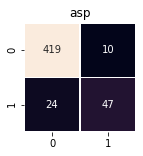

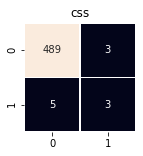

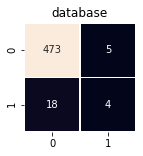

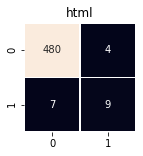

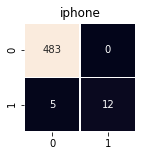

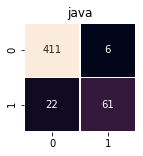

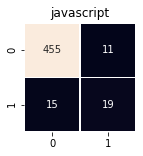

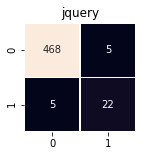

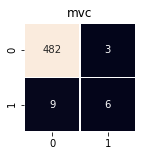

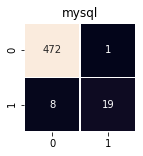

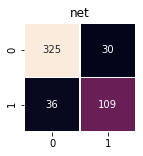

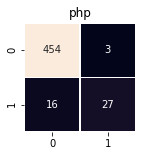

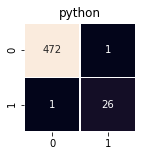

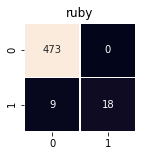

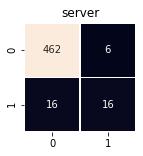

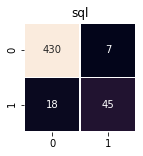

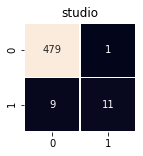

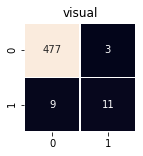

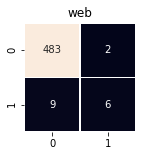

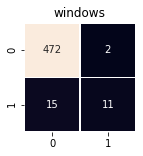

In [26]:
from sklearn.metrics import multilabel_confusion_matrix

ml_confusion_matrix = multilabel_confusion_matrix(y_val, y_pred_val)

for i, label in enumerate(tags.columns.tolist()):
    fig, ax = plt.subplots(figsize=(2,2))
    plt.title(label)
    sns.heatmap(ml_confusion_matrix[i],annot=True, cbar=None,linewidths=.5, fmt="d")

**courbe ROC pour chaques étiquettes - val**

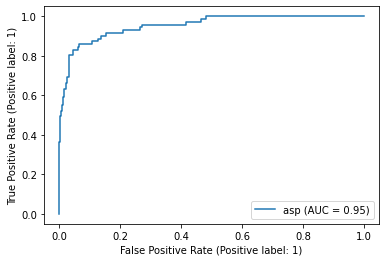

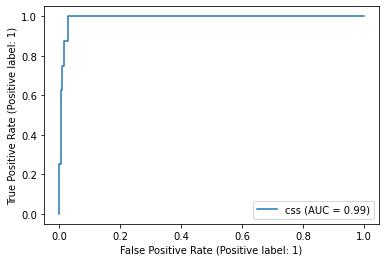

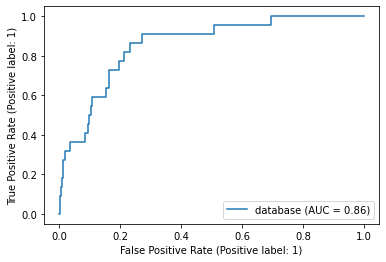

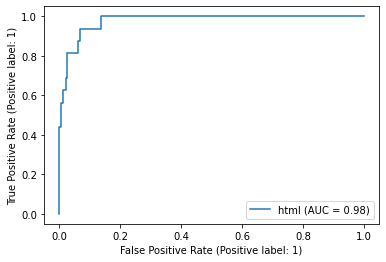

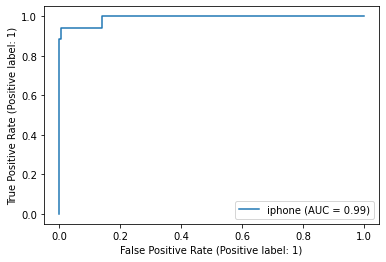

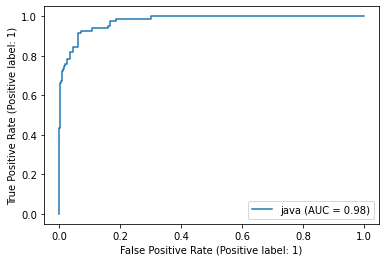

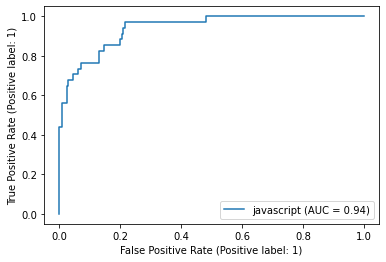

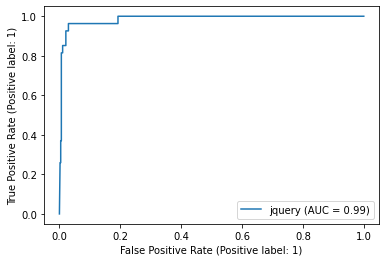

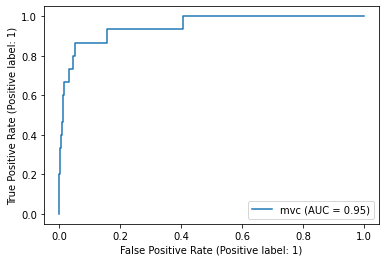

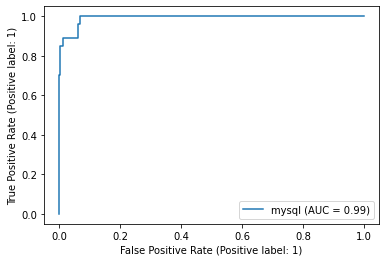

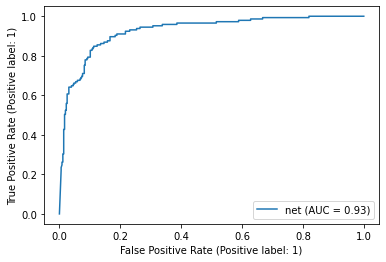

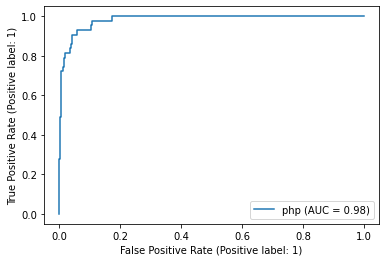

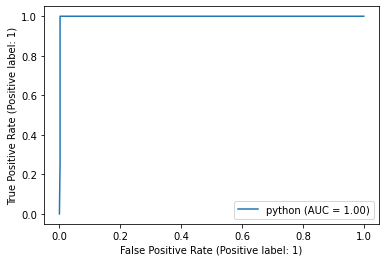

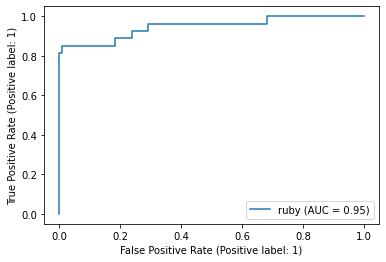

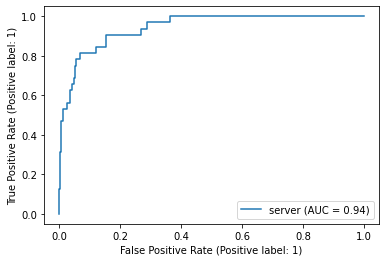

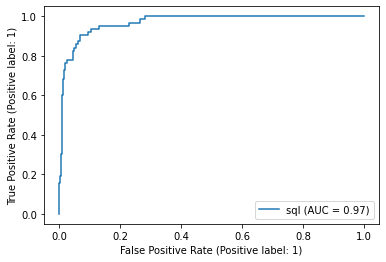

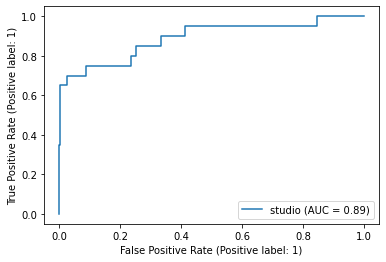

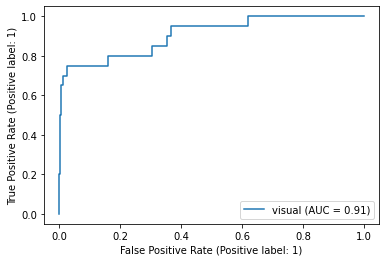

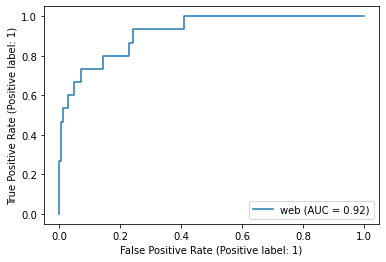

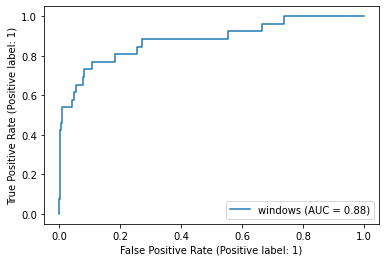

In [27]:
from sklearn.metrics import plot_roc_curve

plt.rcParams.update({'figure.max_open_warning': 0})

for i, label in enumerate(tags.columns.tolist()):
        plot_roc_curve(gscv_logistic_regression.best_estimator_.estimators_[i], X_val_tfidf, y_val[:,i].T, name=label)  

**courbe precision-recall pour chaques étiquettes- val**

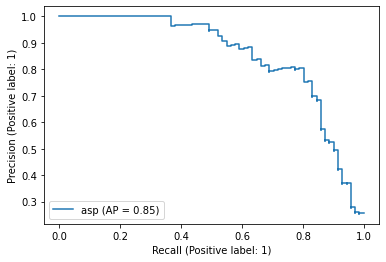

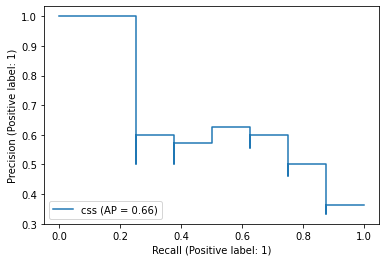

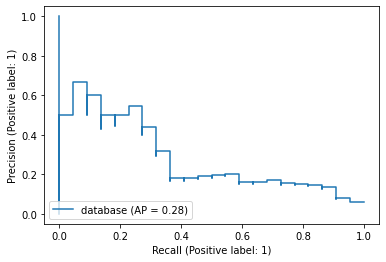

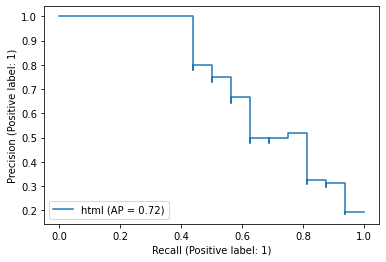

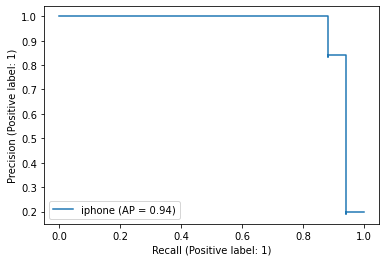

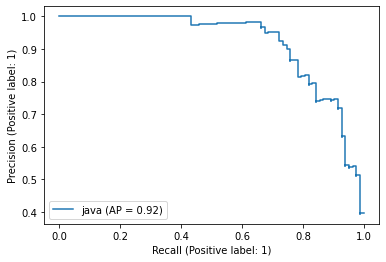

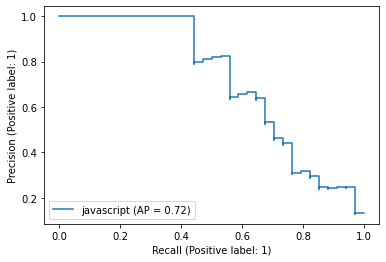

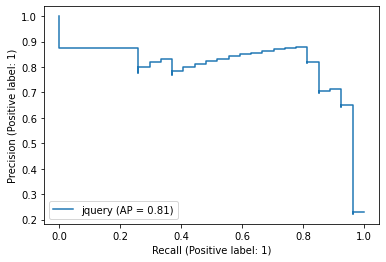

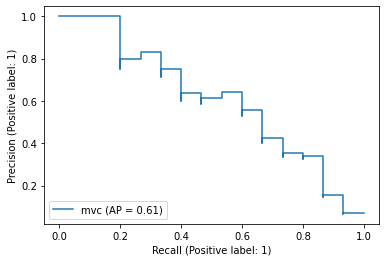

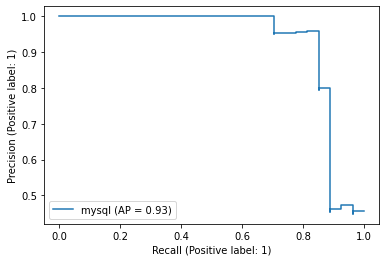

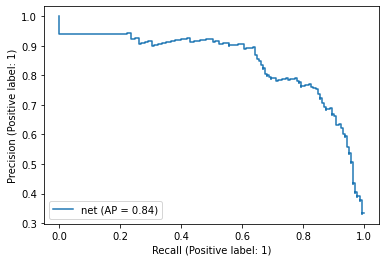

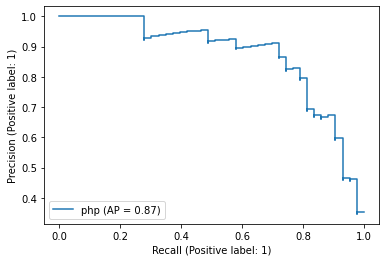

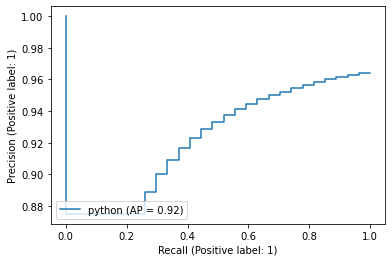

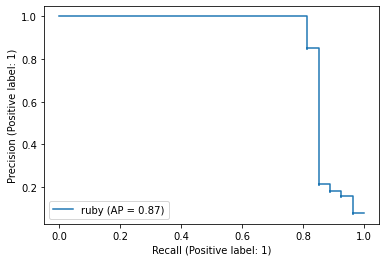

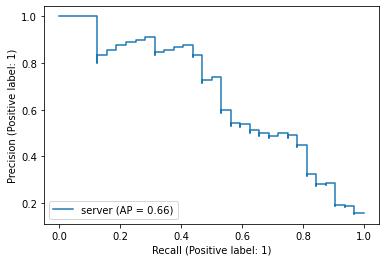

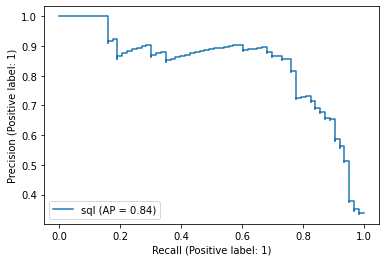

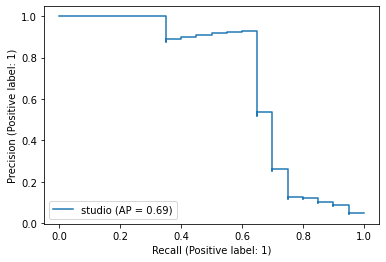

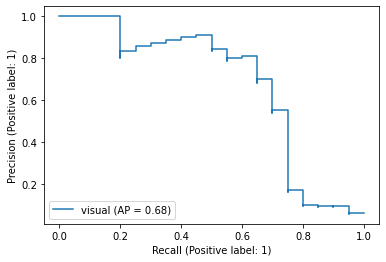

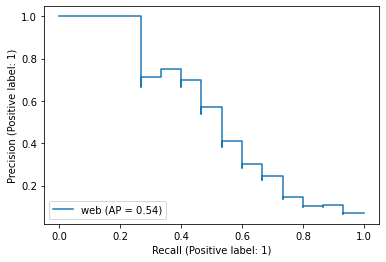

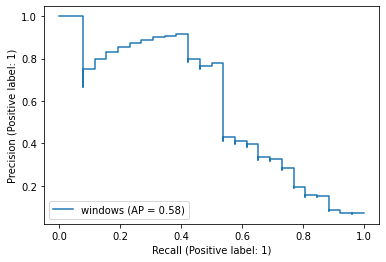

In [28]:
from sklearn.metrics import plot_precision_recall_curve

for i, label in enumerate(tags.columns.tolist()):
        plot_precision_recall_curve(gscv_logistic_regression.best_estimator_.estimators_[i], X_val_tfidf, y_val[:,i].T, name=label)  

**1) classification Random Forest**

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold

random_forest = RandomForestClassifier()

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

hyperparameters = dict(n_estimators = n_estimators,
                       max_features = max_features,
                       max_depth = max_depth,
                       min_samples_split = min_samples_split,
                       min_samples_leaf = min_samples_leaf,
                       bootstrap = bootstrap,
                       n_jobs = n_jobs
                      )

rscv_random_forest = RandomizedSearchCV(random_forest, hyperparameters, n_iter = 50, cv=KFold(3,shuffle=True, random_state=random_state), verbose=2 , random_state=random_state)

rscv_random_forest.fit(X_train_tfidf, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800, n_jobs=4; total time=   8.8s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800, n_jobs=4; total time=   8.7s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800, n_jobs=4; total time=   8.6s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=800, n_jobs=4; total time=   4.4s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=800, n_jobs=4; total time=   4.4s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=800, n_jobs=4; total time=   4.4s
[CV] END bootstrap=False, max_depth=60, max_features=aut

[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=600, n_jobs=4; total time=  12.3s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=600, n_jobs=4; total time=  12.2s
[CV] END bootstrap=False, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800, n_jobs=4; total time=   9.5s
[CV] END bootstrap=False, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800, n_jobs=4; total time=   9.6s
[CV] END bootstrap=False, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800, n_jobs=4; total time=   9.6s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400, n_jobs=4; total time=   1.9s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=4

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400, n_jobs=4; total time=   1.8s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400, n_jobs=4; total time=   1.9s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400, n_jobs=4; total time=   1.8s
[CV] END bootstrap=True, max_depth=85, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000, n_jobs=4; total time=   8.3s
[CV] END bootstrap=True, max_depth=85, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000, n_jobs=4; total time=   8.4s
[CV] END bootstrap=True, max_depth=85, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000, n_jobs=4; total time=   8.5s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=40

RandomizedSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(), n_iter=50,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 35, 60, 85, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000],
                                        'n_jobs': [4]},
                   random_state=42, verbose=2)

In [30]:
rscv_random_forest.best_params_

{'n_jobs': 4,
 'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': False}

In [31]:
y_score_train = rscv_random_forest.predict_proba(X_train_tfidf)
y_pred_train = rscv_random_forest.predict(X_train_tfidf)
classification_report = classification_report.append(get_metrics(y_train, y_score_train, 'random_forest_on_train'))

In [33]:
y_score_val = rscv_random_forest.predict_proba(X_val_tfidf)
y_pred_val = rscv_random_forest.predict(X_val_tfidf)
classification_report = classification_report.append(get_metrics(y_val, y_score_val, 'random_forest_on_val'))

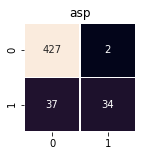

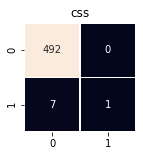

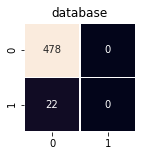

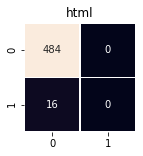

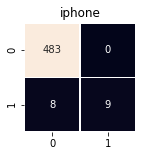

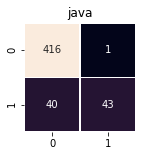

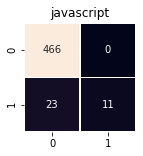

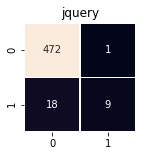

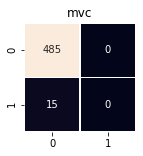

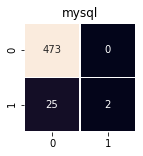

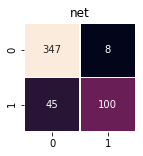

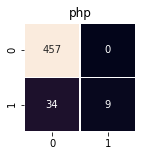

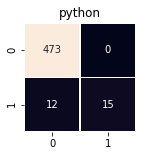

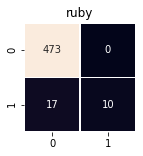

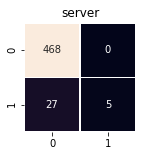

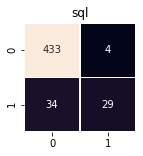

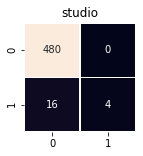

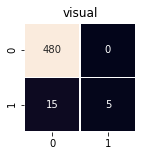

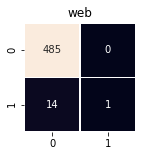

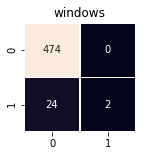

In [38]:
from sklearn.metrics import multilabel_confusion_matrix

ml_confusion_matrix = multilabel_confusion_matrix(y_val, y_pred_val)

for i, label in enumerate(tags.columns.tolist()):
    fig, ax = plt.subplots(figsize=(2,2))
    plt.title(label)
    sns.heatmap(ml_confusion_matrix[i],annot=True, cbar=None,linewidths=.5, fmt="d")

In [51]:
y_score_val

[array([[0.81   , 0.19   ],
        [0.9625 , 0.0375 ],
        [0.6325 , 0.3675 ],
        [0.89625, 0.10375],
        [0.89625, 0.10375],
        [0.99625, 0.00375],
        [0.9825 , 0.0175 ],
        [0.64125, 0.35875],
        [0.8825 , 0.1175 ],
        [0.96125, 0.03875],
        [0.9475 , 0.0525 ],
        [0.89   , 0.11   ],
        [0.92625, 0.07375],
        [0.89   , 0.11   ],
        [0.99   , 0.01   ],
        [0.55375, 0.44625],
        [0.61   , 0.39   ],
        [0.45125, 0.54875],
        [0.95   , 0.05   ],
        [0.845  , 0.155  ],
        [0.95875, 0.04125],
        [0.95875, 0.04125],
        [0.3925 , 0.6075 ],
        [0.93375, 0.06625],
        [0.95125, 0.04875],
        [0.28375, 0.71625],
        [0.9675 , 0.0325 ],
        [0.92125, 0.07875],
        [0.98375, 0.01625],
        [0.8725 , 0.1275 ],
        [0.9225 , 0.0775 ],
        [0.90875, 0.09125],
        [0.93375, 0.06625],
        [0.9475 , 0.0525 ],
        [0.9675 , 0.0325 ],
        [0.97625, 0.

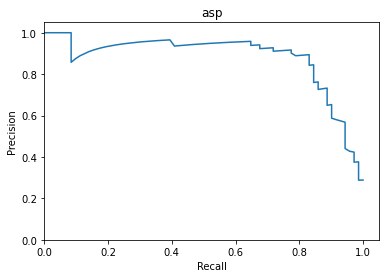

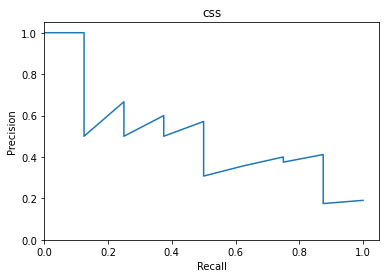

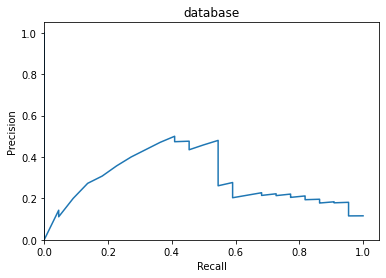

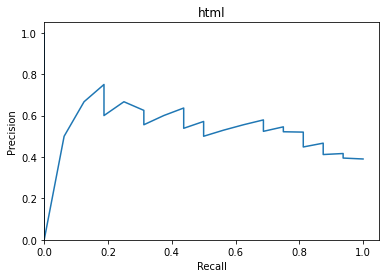

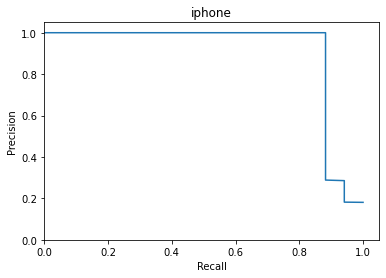

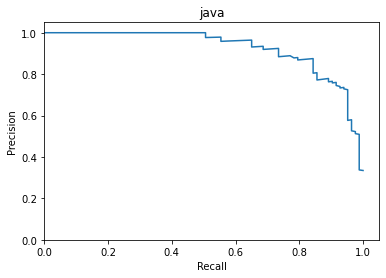

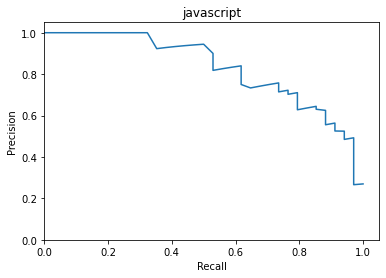

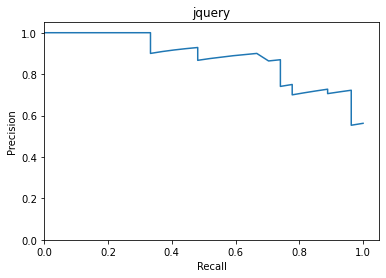

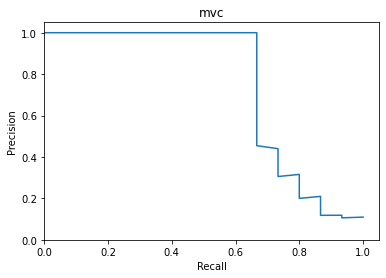

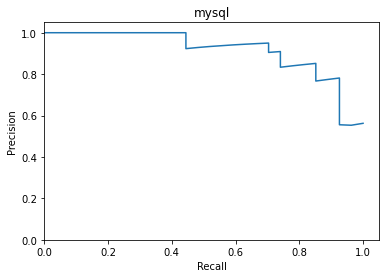

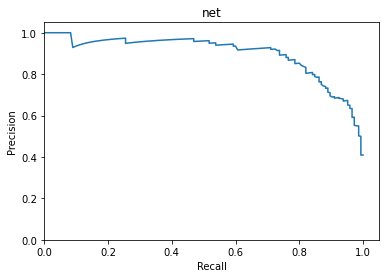

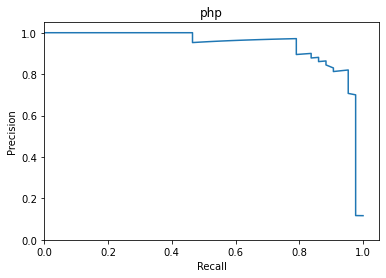

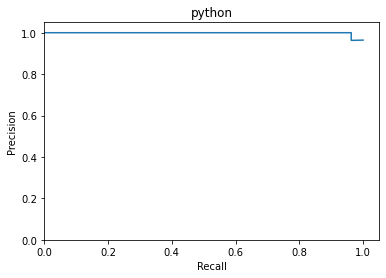

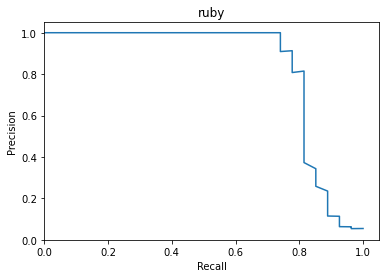

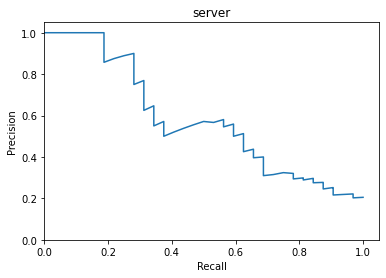

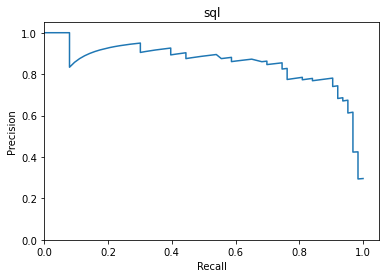

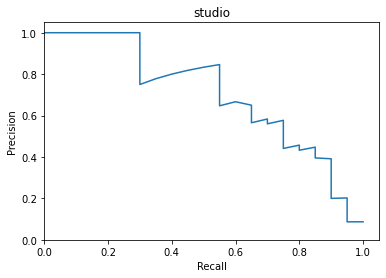

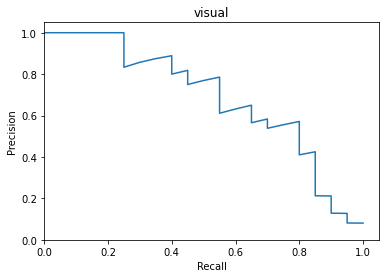

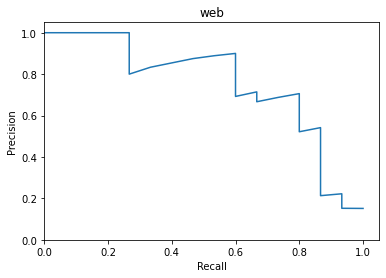

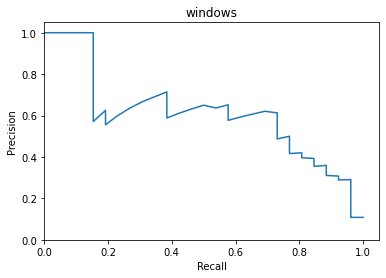

In [62]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

def plot_aupr(y_true, y_score, labels):
    precision = dict()
    recall = dict()
    average_precision = dict()
    probs = np.transpose([prob[:, 1] for prob in y_score])
    for i in range(20):
        precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], probs[:, i])
        plt.figure()
        plt.plot(recall[i], precision[i])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.05])
        plt.title(labels[i])
        
plot_aupr(y_val,y_score_val, labels=tags.columns.tolist())
#plot_aupr(y_train,y_score_train, labels=tags.columns.tolist())

**rapport de Classification**

<AxesSubplot:title={'center':'Train - Rapport de classification'}>

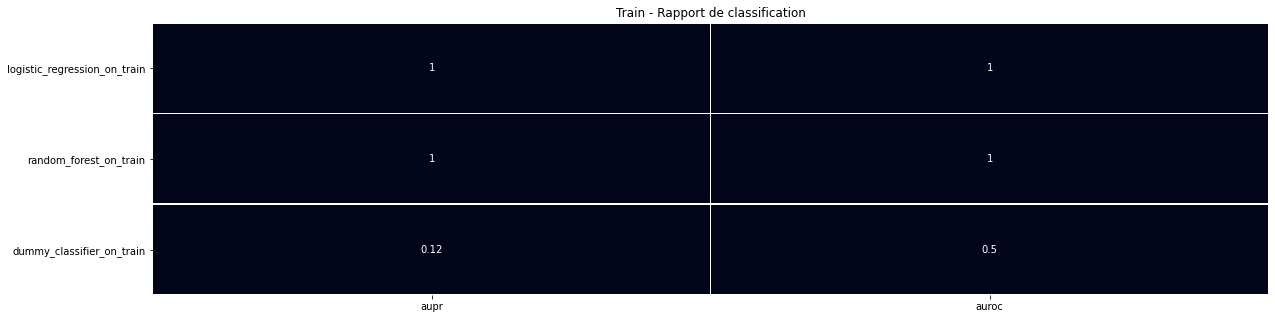

In [35]:
cr = classification_report[classification_report.index.str.contains('train$')].sort_values(by=['auroc'], ascending=False)

fig, ax = plt.subplots(figsize=(20,5))
plt.title('Train - Rapport de classification')
sns.heatmap(cr, vmin=classification_report.max().max(), vmax=classification_report.max().max(), annot=True, cbar=None,linewidths=.5)

<AxesSubplot:title={'center':'Val - Rapport de classification'}>

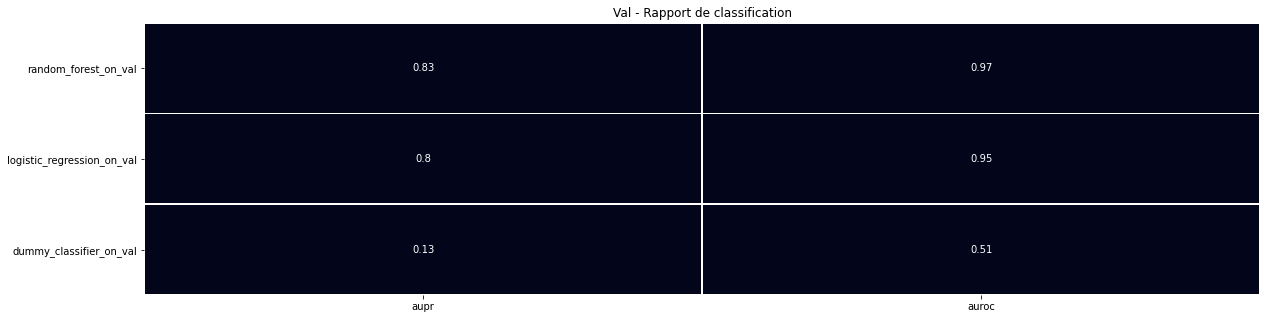

In [36]:
cr = classification_report[classification_report.index.str.contains('val$')].sort_values(by=['auroc'], ascending=False)

fig, ax = plt.subplots(figsize=(20,5))
plt.title('Val - Rapport de classification')
sns.heatmap(cr, vmin=classification_report.max().max(), vmax=classification_report.max().max(), annot=True, cbar=None,linewidths=.5)

**Test à l'échelle**

In [ ]:
posts = pd.read_csv("data/multi_posts.csv")
tags = pd.read_csv("data/multi_posts_tags.csv")
multi_posts = pd.concat([posts,tags], axis=1)
multi_posts.insert(2,'body_title',posts['body']+'   '+posts['title'])
multi_posts= multi_posts.drop(['body','title'], axis=1)
multi_posts = multi_posts.dropna()
X, y = multi_posts['body_title'], multi_posts.iloc[:,1:].to_numpy(copy=True, dtype='int32')
X_tfidf = multi_tfidf_vectorizer.transform(X)
classification_report = pd.DataFrame()

In [ ]:
y_pred = gscv_logistic_regression.predict(X_tfidf)
classification_report = classification_report.append(get_metrics(y, y_pred, 'logistic_regression_on_all'))

In [ ]:
y_pred = gscv_random_forest.predict(X_tfidf)
classification_report = classification_report.append(get_metrics(y, y_pred, 'random_forest_on_all'))

In [ ]:
cr = classification_report[classification_report.index.str.contains('all$')].sort_values(by=['roc_auc_score'], ascending=False)

fig, ax = plt.subplots(figsize=(20,5))
plt.title('all - Rapport de classification')
sns.heatmap(cr, vmin=classification_report.max().max(), vmax=classification_report.max().max(), annot=True, cbar=None,linewidths=.5)

**fonction pour api prediction**

In [ ]:
# retourne les étiquettes pour les predictions
def labels(predictions, labels):
    preds = []
    for prediction in predictions:
        pred = []
        for i, is_label in enumerate(prediction):
            if is_label == 0:
                pass
            else :
                pred.append(labels[i])
        preds.append(pred)
    return preds
        
labels(y_pred_val, labels=tags.columns.tolist())